In [161]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc

In [162]:
# Load the teams data
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'Rank', 'PlayoffProgScore', 'FTA', 'DREB', 'AST', 'TOV', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

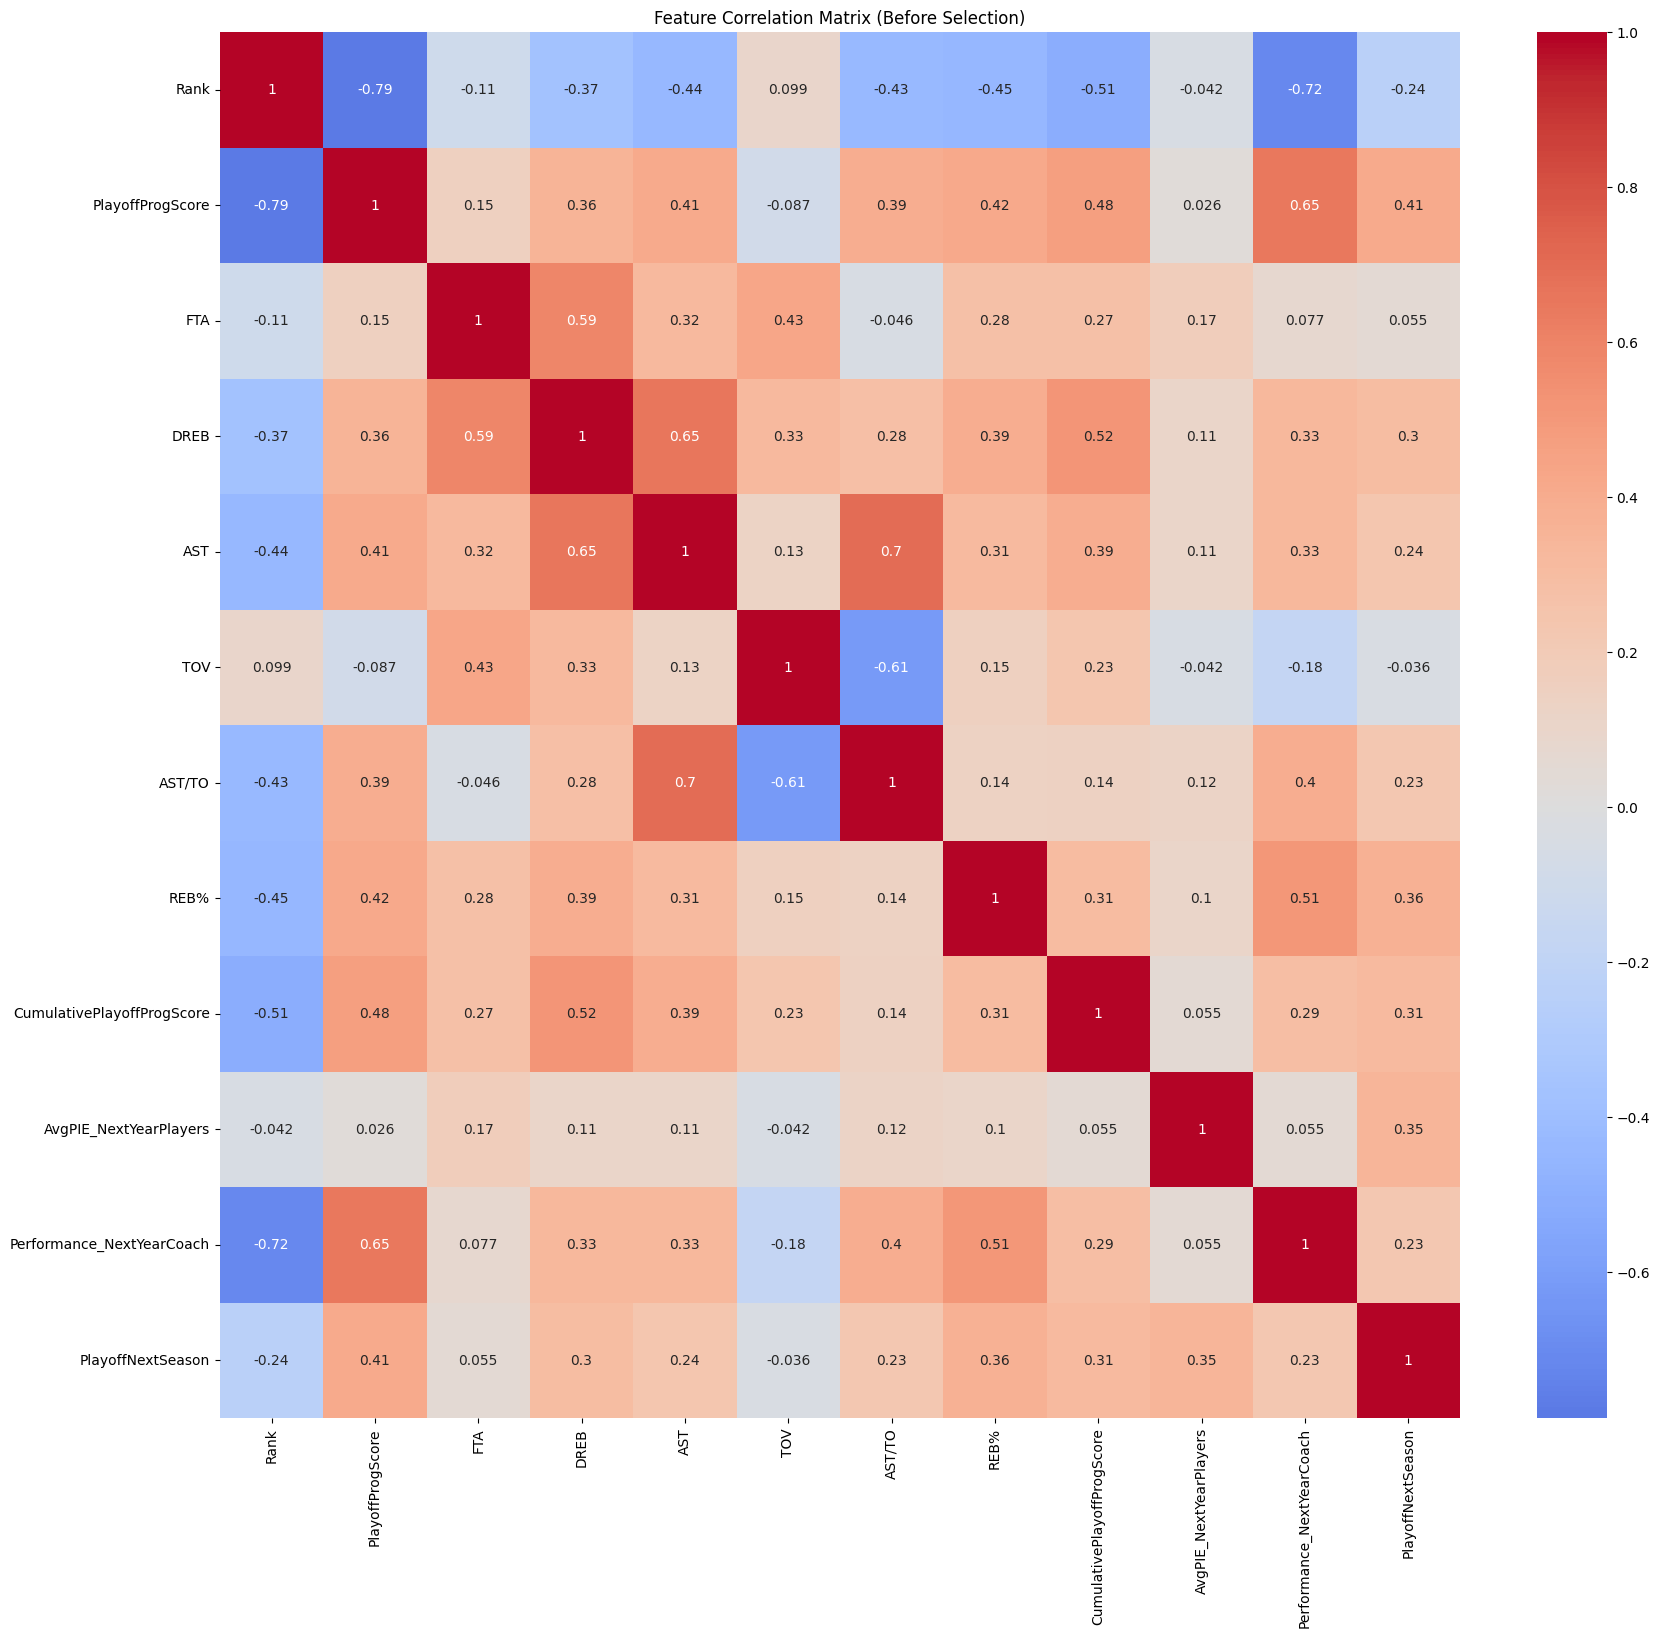

In [163]:
# ============================
# Display Initial Correlation Matrix
# ============================

# Calculate and plot the correlation matrix
correlation_matrix = dataset[features + [label]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Before Selection)')
plt.show()

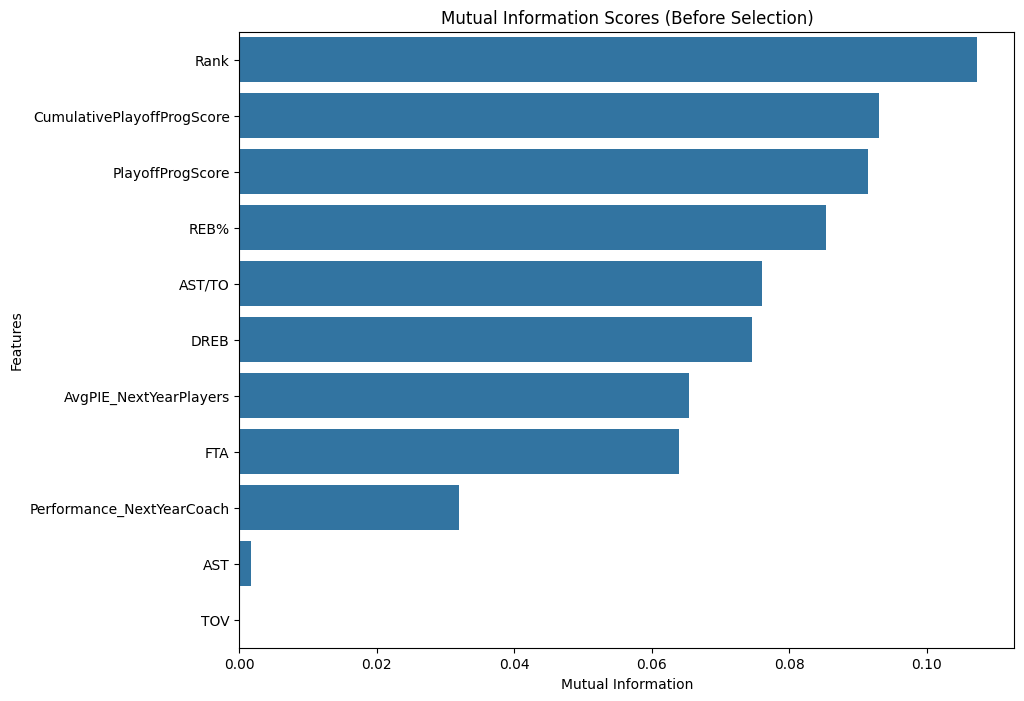

In [164]:
# ============================
# Display Initial Mutual Information Scores
# ============================

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.title('Mutual Information Scores (Before Selection)')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

In [165]:
# ============================
# Define the XGBoost model
# ============================

def create_model(trial):
    return XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 100)
    )

In [166]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

In [167]:
# ============================
# Hyperparameter Tuning with Optuna
# ============================
def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.6 * mean_accuracy + 0.4 * mean_auc
    
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)

final_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')

[I 2024-12-20 12:42:53,504] A new study created in memory with name: no-name-dded2057-8789-4e01-824c-ceeddb49ddd8
[I 2024-12-20 12:42:53,710] Trial 1 finished with value: 0.7531292517006802 and parameters: {'learning_rate': 0.26902490549582986, 'n_estimators': 200, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6023165193620286, 'colsample_bytree': 0.7541051518756584, 'gamma': 3.8025622212627526, 'reg_alpha': 0.6266591752171502, 'reg_lambda': 0.08919650713508998, 'scale_pos_weight': 75.4945212185625}. Best is trial 1 with value: 0.7531292517006802.
[I 2024-12-20 12:42:53,830] Trial 2 finished with value: 0.7834438775510204 and parameters: {'learning_rate': 0.2957328430436294, 'n_estimators': 471, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6996531129377068, 'colsample_bytree': 0.8601957322844495, 'gamma': 2.7772904486772183, 'reg_alpha': 0.4248832020495549, 'reg_lambda': 0.6317206241903397, 'scale_pos_weight': 92.93755015183679}. Best is trial 2 with value: 0.783443877

Best Hyperparameters: {'learning_rate': 0.1528464747311271, 'n_estimators': 163, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7375587829619862, 'colsample_bytree': 0.5345884239912794, 'gamma': 0.4883758415316557, 'reg_alpha': 0.9967277690375889, 'reg_lambda': 0.13087485458677553, 'scale_pos_weight': 21.054973698101676}
Best Value: 0.8395663265306124


,Feature,Average Importance
0,Rank,0.123332
5,TOV,0.109092
3,DREB,0.105761
7,REB%,0.099020
10,Performance_NextYearCoach,0.090347
8,CumulativePlayoffProgScore,0.085768
9,AvgPIE_NextYearPlayers,0.081782
6,AST/TO,0.081441
1,PlayoffProgScore,0.080466
4,AST,0.074088


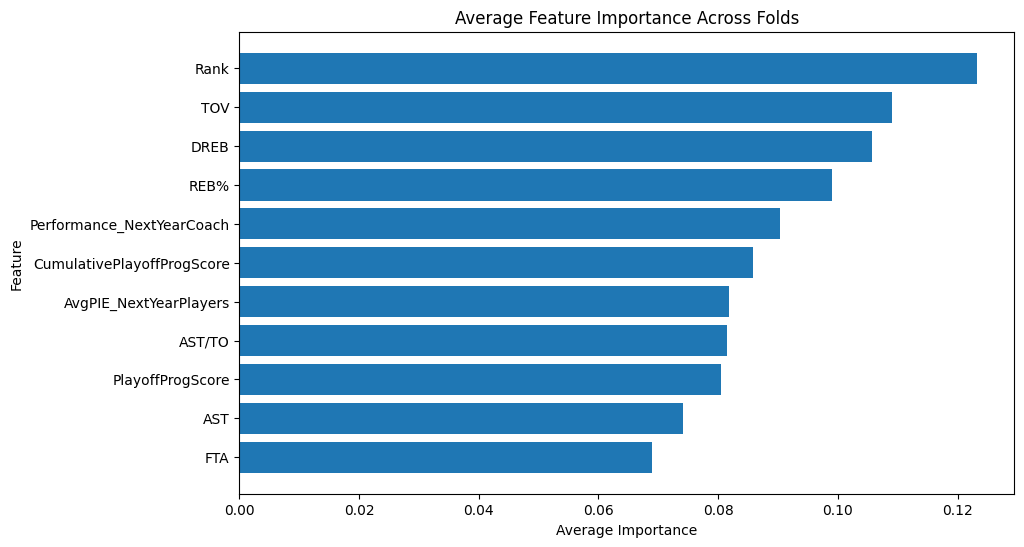

Mean Cross-Validation Accuracy: 0.7957142857142858
Mean Cross-Validation Precision: 0.7403282828282828
Mean Cross-Validation Recall: 0.9589285714285716
Mean Cross-Validation F1 Score: 0.8292684766214178
Mean Cross-Validation AUC Score: 0.8834183673469388
Mean Cross-Validation Specificity: 0.6321428571428571


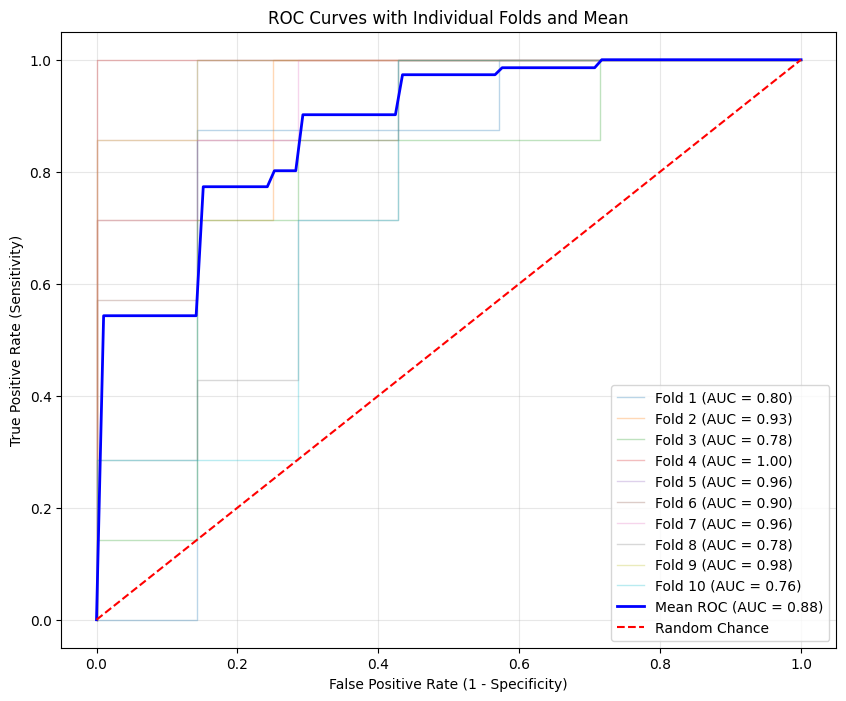

In [168]:
# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

average_importances = np.mean(feature_importances, axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# Display the feature importance table
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()